In [2]:
# USE recurrent neural network long short term memory(LSTM)
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader.data as web

from datetime import datetime
from datetime import timedelta
import os
import matplotlib.pyplot as plt
import math

In [3]:
pd.set_option("display.max_rows",100)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [6]:
df= web.DataReader('ARLO', 'yahoo', start=datetime(2015, 1, 1), end=datetime(2021, 2, 25))


In [8]:
#generate next five weekdate for future plotting
def next_five_weekdate():
    fivedate=[]
    n=1
    while len(fivedate)<5:
        newdate=datetime.today()+ timedelta(days=n)
        if (newdate.weekday()!=5) & (newdate.weekday()!=6):
            fivedate.append(newdate.strftime('%Y-%m-%d'))
        n+=1
    return fivedate    

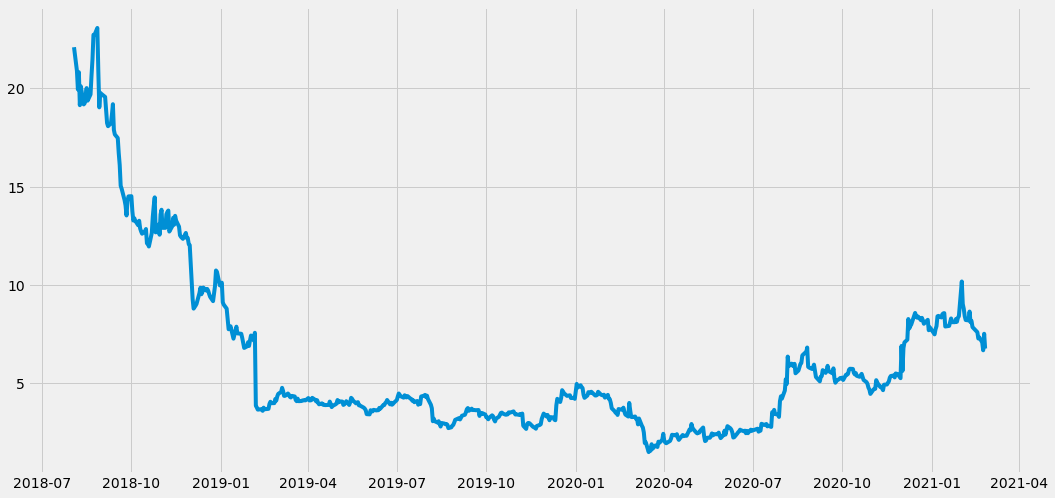

In [12]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.plot(df.Close)

In [13]:
data=df.Close.values.reshape(-1,1)

In [14]:
# 80% training data set
training_data_len=math.ceil(len(data)*0.8)

In [15]:
training_data_len

516

In [16]:
data.shape

(645, 1)

In [17]:
# Scale the data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data)

In [18]:
#create trainning data set
train_data=scaled_data[0:training_data_len]

In [19]:
x_train=[]
y_train=[]

In [20]:
for i in range(90,len(train_data)):
    x_train.append(train_data[i-90:i])
    y_train.append(train_data[i])

In [21]:
#convert to numpy array
x_train,y_train =np.array(x_train),np.array(y_train)

In [22]:
model=Sequential()

In [23]:
#build the LSTM model
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [24]:
# complie the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [25]:
model.fit(x_train,y_train,batch_size=1,epochs=1)


426/426 [==============================] - 15s 26ms/step - loss: 0.0029


In [26]:
#create testing data set
test_data=scaled_data[training_data_len-90:]

# split into x_test , y_test
x_test=[]
y_test=data[training_data_len:]

In [27]:
for i in range(90,len(test_data)):
    x_test.append(test_data[i-90:i])

In [28]:
x_test=np.array(x_test)

In [29]:
preditions=model.predict(x_test)

In [30]:
preditions=scaler.inverse_transform(preditions)

In [31]:
#test_error_Rate=model.evaluate(x_test,y_test)
#test_error_Rate


In [32]:
#plot the data
train=df[:training_data_len]
valid=df[training_data_len:]
valid['Preditions']=preditions


<ipython-input-32-539c736768d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Preditions']=preditions


In [33]:
valid

,High,Low,Open,Close,Volume,Adj Close,Preditions
Date,,,,,,,
2020-08-21,6.69,5.92,5.93,6.42,3403000,6.42,5.925332
2020-08-24,7.30,6.53,6.60,6.56,2947300,6.56,5.979874
2020-08-25,6.76,6.35,6.58,6.56,1755400,6.56,6.058786
2020-08-26,6.96,6.52,6.58,6.82,1274900,6.82,6.147022
2020-08-27,6.98,5.74,6.91,5.84,3418700,5.84,6.252610
...,...,...,...,...,...,...,...
2021-02-19,7.55,7.30,7.34,7.34,840700,7.34,7.872687
2021-02-22,7.36,7.05,7.29,7.08,1401200,7.08,7.739429
2021-02-23,6.96,6.08,6.91,6.68,3285100,6.68,7.600520


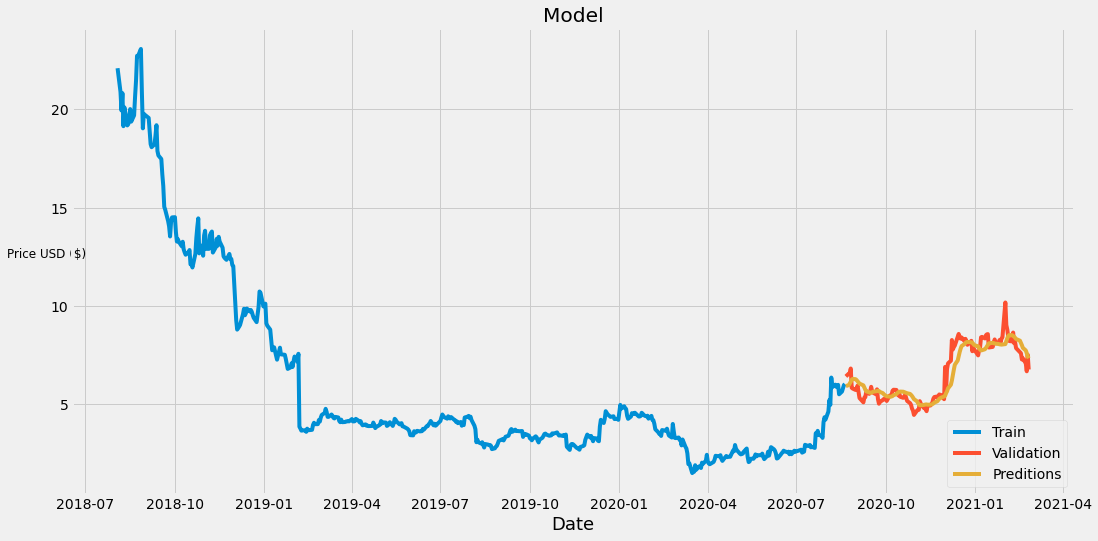

In [34]:
#visualize the data
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Preditions']])
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=12 ,rotation='horizontal')
plt.legend(['Train','Validation','Preditions'],loc='lower right')
plt.show()

In [46]:
#predict future price
df= web.DataReader('ARLO', 'yahoo', start=datetime(2019, 3, 21), end=datetime(2021, 2, 21))

In [47]:
#only use close price
new_df=df.filter(['Close'])
#use last 95 days to predict next 5 days as 90 training data required for predict 1 day
last_95_days=new_df[-95:].values
#scale the data to be values between 0 and 1
last_95_days_scaled=scaler.transform(last_95_days)


In [48]:
#create empty list
predict_test=[]
#append last 95 days
for i in range(90,95):
    predict_test.append(last_95_days_scaled[i-90:i])

#convert to numpy array
predict_test=np.array(predict_test)


In [51]:
future_price= model.predict(predict_test)
future_price=scaler.inverse_transform(future_price)


In [52]:
future_price

array([[8.324128],
       [8.236779],
       [8.127439],
       [8.009509],
       [7.872687]], dtype=float32)

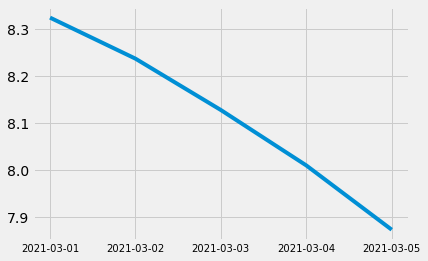

In [53]:
plt.plot(next_five_weekdate(),future_price )
plt.xticks(fontsize=10)
plt.show()